In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/S&P 500 Realized Volatility (NBEATSx).xlsx",index_col='Date',parse_dates=True)


Mounted at /content/drive


In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 1544938


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77146857


Epoch: 200 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0018614378089514248 | Accuracy: 64.71080463244196


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 125296329


Epoch: 100 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.05
RMSE: 2.0009033225891866 | Accuracy: -39990.926950304274


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 51595670


Epoch: 100 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: DistributionLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 21035.88680216734 | Accuracy: -450674456.59982955


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93749110


Epoch: 200 | Inputs: 189 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.0014587338725150223 | Accuracy: 71.68987183857959


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0018677265892732308 | Accuracy: 67.4573274361363


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 99319078


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 36034262


Epoch: 150 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001
RMSE: 0.00142462762746726 | Accuracy: 72.0389728738247


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108696059


Epoch: 200 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.0020002977802183416 | Accuracy: 62.898360785665815


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 127040314


Epoch: 200 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.05
RMSE: 0.4167431598913066 | Accuracy: -8080.164363932194


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34182858


Epoch: 150 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.0017473455638545071 | Accuracy: 64.31532540671954


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001
RMSE: 0.001543834404486738 | Accuracy: 70.16908815480092


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 2465999


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91097838


Epoch: 150 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005
RMSE: 0.0019833313845582334 | Accuracy: 60.027552965356826


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 88423633


Epoch: 150 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 1593.7728129479399 | Accuracy: -31365203.23478096


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20338404


Epoch: 100 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.001717227592265856 | Accuracy: 66.74444128549293


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 70643941


Epoch: 150 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 10.681825693530309 | Accuracy: -182329.0829811039


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

Epoch: 150 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001

RMSE: 0.00142462762746726 | Accuracy: 72.0389728738247

# H=1 Forecasts

In [ ]:
df=df[:len(df["y"])-1]

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
model = NBEATSx(h=1, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=150,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 54883263


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
Accuracy

[64.10737726286689,
 64.92614276329476,
 64.22483991590755,
 65.04787432677107,
 64.56569145001717,
 64.80354353004704,
 64.39712853610331,
 64.32811206411063,
 65.55145346855616,
 64.5916400147677,
 64.58841743566619,
 64.37008327205902,
 63.96149882723011,
 64.57171505253379,
 64.65496044022575]

In [ ]:
RMSE

[0.0025052995254504985,
 0.0025032366021163753,
 0.0024728545557797504,
 0.0025100894766926806,
 0.0024789293745090713,
 0.0024787454786862288,
 0.0024718452691074267,
 0.0024793793184209887,
 0.002485347831890803,
 0.002514135761932056,
 0.0024681898642713927,
 0.0024967555864834822,
 0.0025069514431016564,
 0.0025157646376539676,
 0.0024996801694914697]

In [ ]:
Quasilikelihood

[0.0925152495782314,
 0.08975444415623268,
 0.08836638956502718,
 0.08842246880652556,
 0.09090078596200148,
 0.08904088999032733,
 0.09085420534649878,
 0.08888218690274433,
 0.0880504022435064,
 0.09047917520119751,
 0.08780394917233114,
 0.09587310548514293,
 0.09175024654812985,
 0.09178918333330983,
 0.09176993916348668]

Text(0, 0.5, 'S&P 500 Realized Volatility')

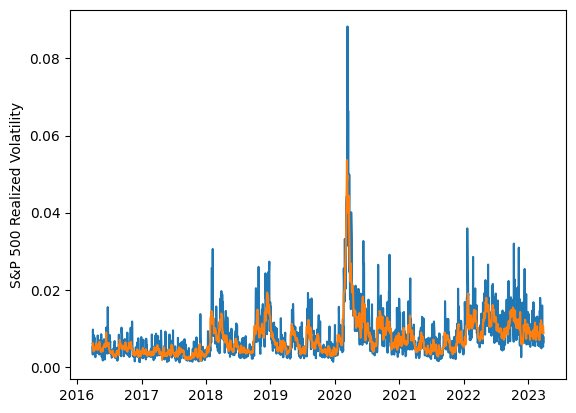

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=3 Forecasts

In [ ]:
df=df[:len(df["y"])-1]
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [ ]:
model = NBEATSx(h=3, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=150,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=3)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 74254060


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0024880440018266075,
 0.002572153351916443,
 0.0025404730042301693,
 0.0025322626115181802,
 0.0025404880044964584,
 0.002546001034999552,
 0.0025380184528585267,
 0.0025451221509278743,
 0.0025575920360613636,
 0.0024733616265761576,
 0.0025109733990882695,
 0.0024796286393316247,
 0.002490105305920653,
 0.0024732898567165506,
 0.002507200356959586]

In [ ]:
Accuracy


[64.26323769763746,
 62.428594788809896,
 63.73149298239753,
 64.31353931496271,
 63.99418808150703,
 64.14216212109237,
 63.39623512463922,
 64.13262778422197,
 64.05180864214712,
 64.46152712448301,
 64.14703403360357,
 65.25347427467494,
 64.4777696648972,
 64.67889345934641,
 64.68047683821203]

In [ ]:
Quasilikelihood

[0.08766379363022744,
 0.09327997333605152,
 0.09485166947574741,
 0.0933830259546815,
 0.09308236480504922,
 0.09498920542272919,
 0.0916536255976608,
 0.09324673620866522,
 0.09685977868904977,
 0.08471718970596179,
 0.09032525841820953,
 0.08844577610393034,
 0.09003610583518888,
 0.08699238494427682,
 0.09197973524916805]

Text(0, 0.5, 'S&P 500 Realized Volatility')

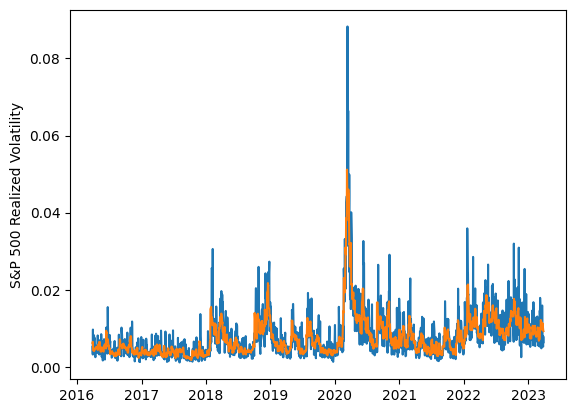

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=5 Forecasts

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=5, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=150,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 50031640


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0026496416577804745,
 0.002744628501069334,
 0.002716399801498647,
 0.002669508373701628,
 0.0027210236191351545,
 0.002740592862221398,
 0.002665094337318517,
 0.002675315978032872,
 0.002676825382036834,
 0.0026620157705054743,
 0.002611306160848748,
 0.0026495948199777293,
 0.0026990753101263578,
 0.002760593127683543,
 0.0027012282690781135]

In [ ]:
Accuracy

[62.65771614379434,
 61.14865160167901,
 61.741360286388705,
 62.672386509799516,
 61.2619074257454,
 61.047031264171856,
 62.56680586043187,
 62.62019789686322,
 62.13680815346932,
 62.89848589071351,
 63.01794539471109,
 62.78517444042112,
 61.19970270097815,
 60.84327539761034,
 61.61668694433096]

In [ ]:
Quasilikelihood

[0.09735178176155326,
 0.10675376808473447,
 0.10327150474531277,
 0.09987509686060801,
 0.10109842569413806,
 0.10345006655120724,
 0.09850642106901564,
 0.1006647349621929,
 0.10043569575114886,
 0.10090553947440359,
 0.09303723301758234,
 0.09674171755739326,
 0.09905057508294747,
 0.10538391548999969,
 0.1014314721970981]

Text(0, 0.5, 'S&P 500 Realized Volatility')

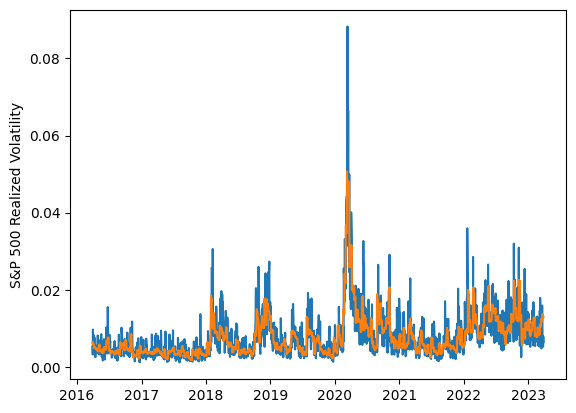

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=10 Forecasts

In [ ]:
test_length=1750

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=10, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=150,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=10)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 78036284


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.002852797558316458,
 0.0029435178555013096,
 0.002991406884422472,
 0.0028741832604490453,
 0.00290507502625606,
 0.0029389386376412158,
 0.0028834847975487054,
 0.0029525333779756345,
 0.002934578709173027,
 0.0029603895850488977,
 0.0029416886903147863,
 0.002876233527896956,
 0.0029452866324591437,
 0.0029010497694187524,
 0.002894590778321442]

In [ ]:
Accuracy

[61.33420626153057,
 59.74868463201619,
 58.62761979466795,
 60.28646173188055,
 60.87596360048927,
 59.768764891367134,
 60.75839258197377,
 59.526428187953975,
 59.664283425941456,
 59.14475889412265,
 59.216062510533376,
 60.22968190921652,
 59.28431095259358,
 60.427032009553805,
 60.69104207022041]

In [ ]:
Quasilikelihood

[0.1144536798981151,
 0.12335351697812705,
 0.12407355768415507,
 0.11183046358773671,
 0.12068048299636822,
 0.12161656038991944,
 0.11902379675928648,
 0.12292403281592264,
 0.119268949962086,
 0.121378997596578,
 0.12166395150528111,
 0.11503579154615713,
 0.12019707728940802,
 0.1186612429021283,
 0.11817110931257528]

Text(0, 0.5, 'S&P 500 Realized Volatility')

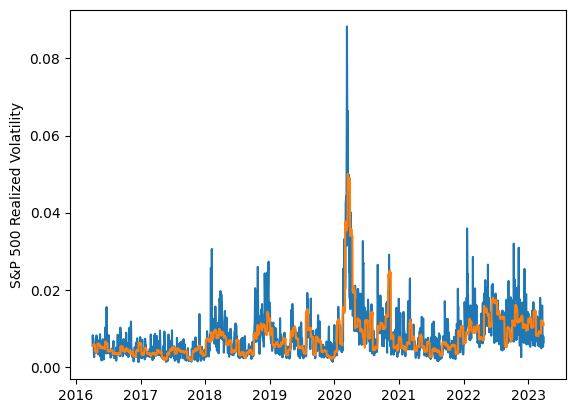

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")

# H=22 Forecasts

In [ ]:
test_length=1738

In [ ]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=22, input_size=21,
                loss=MQLoss(level=[90]),
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['identity','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=5,
                val_check_steps=100,
                n_harmonics=0, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=150,
                early_stop_patience_steps=1,
                random_seed=randrange(129228148)
                )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=22)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 97379490


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
RMSE

[0.0033885237356452796,
 0.0033637838514592507,
 0.003410450714337739,
 0.0033818700028117963,
 0.0033816521542261078,
 0.0033209668730972497,
 0.0033665794594797418,
 0.003371295386624295,
 0.003353884782551786,
 0.0034102830650308944,
 0.0033781981014752104,
 0.003395223958118318,
 0.003400026696193838,
 0.0033389599091231234,
 0.003365067665320516]

In [ ]:
Accuracy

[51.120434848671835,
 51.80084711348609,
 50.88221084687448,
 51.555278197690846,
 51.49475274620225,
 52.4761486095325,
 52.11321008964688,
 51.238373010554874,
 52.38595125440351,
 50.804316966060135,
 51.469515646884915,
 50.67932971378444,
 51.623274108535334,
 52.22934555122383,
 52.25657518122979]

In [ ]:
Quasilikelihood

[0.16547290722148034,
 0.16893486442699243,
 0.1703631121483709,
 0.17027536911663144,
 0.17104861262333426,
 0.1649189366504627,
 0.16701268018502702,
 0.16577017377126066,
 0.17206230591930782,
 0.17015727615151852,
 0.1675033521708046,
 0.16377000483110693,
 0.17775558384025397,
 0.16643776964004436,
 0.16899849046235393]

Text(0, 0.5, 'S&P 500 Realized Volatility')

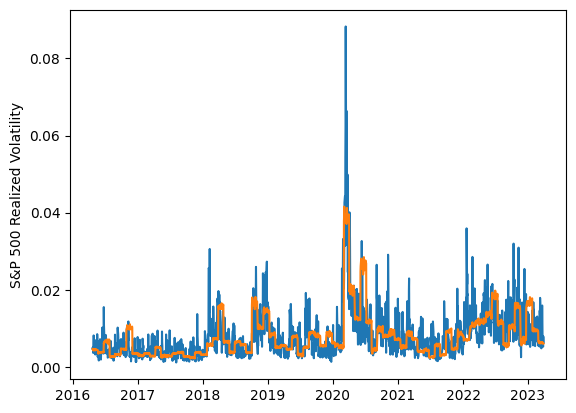

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")